In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML

In [140]:
from Backtesting import *

In [170]:
directory = "O:/AARM/Direct/Top Holdings/Research/Biotech/NW/"

bt_data = BacktesterData(
    holdings_path=directory + 'Output/holdings.csv',
    sec_master_path=directory + 'Output/security_master.csv',
    sec_mapping_path=directory + 'Output/security_mapping.csv',
    sec_out_path=directory + 'Output/security_out.csv',
    managers_path=directory + 'Input/managers.xlsx'
)

In [171]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
bt = FilingBacktester(bt_data)


In [143]:
test_fund = "RA"
test_holdings = bt.get_fund_holdings(test_fund, eligible_securities=False)

test_holdings_long = test_holdings.reset_index().melt(
    id_vars='holding_date',
    var_name='Ticker',
    value_name='Weight'
).query('Weight > 0').sort_values(['holding_date', 'Weight'], ascending=[True, False])  # Sort by date then by weight descending

# Copy to clipboard
test_holdings_long.to_clipboard()

In [144]:
returns, attr, weights = bt.get_strategy_returns(test_holdings, end_date=pd.Timestamp('2025-05-15'))
returns.to_clipboard()

In [145]:
consolidated_error_df = bt_data.error_df.groupby(['Ticker', 'Name']).agg({
    'holding_date': ['min', 'max'],
    'value': 'sum',
    'Min_Px_Date': 'min',
    'Max_Px_Date': 'max'
}).reset_index()
consolidated_error_df.columns = ['Ticker', 'Name', 'min_holding_date', 'max_holding_date', 'value', 'Min_Px_Date', 'Max_Px_Date']
consolidated_error_df = consolidated_error_df.sort_values('value', ascending=False)

# Exclude securities I have already verified are from erroneus filings
excluded_tickers = ['SVA US', #Private, reported holdings values are stale
                    'DCPH US', #Acquired
                    'BLU CN', #Acquired
                    'ZGNX US', #Acquired
                    '1284849DUS', #Acquired
                    'ALPN US', #Acquired
                    'PRXL US', #Delisted
                    'QP/ LN', #Private
                    ]
consolidated_error_df = consolidated_error_df[~consolidated_error_df['Ticker'].isin(excluded_tickers)]

print("Top errors by value:")
# Set display options to show more rows
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
print(consolidated_error_df)

Top errors by value:
                   Ticker                                          Name min_holding_date max_holding_date      value Min_Px_Date Max_Px_Date
68                VYNE US                        VYNE Therapeutics Inc.       2014-12-31       2017-12-31  661.76397  2018-01-24  2025-05-15
0   #N/A Invalid Security                                    IMARA Inc.       2020-03-31       2022-12-31  484.23242         NaT         NaT
42                NEUP US                   Neuphoria Therapeutics Inc.       2017-06-30       2021-09-30  226.42897  2021-12-15  2025-05-15
70                ZCOR US                            Zyla Life Sciences       2014-12-31       2018-12-31  114.06768  2019-03-21  2020-05-18
3              1891847DUS                 Centrexion Therapeutics Corp.       2018-03-31       2024-12-31   95.24072         NaT         NaT
66                VRNA US                             Verona Pharma plc       2014-12-31       2017-03-31   92.45430  2017-04-26  202

In [147]:
mkt_cap = bt.sec_mkt_cap_df
eligible = bt.eligible_securities_df
rets = bt.sec_rets_df
valid_rets = (rets == 0).sum(axis=1) < 0.9*len(rets.columns)
mkt_cap = mkt_cap.multiply(eligible)
mkt_cap = mkt_cap.replace(0, np.nan)
mkt_cap = mkt_cap.loc[valid_rets]
rets = rets.loc[valid_rets]

# Size
size_score = np.log(mkt_cap)
size_score = bt.standardize_factor_scores(size_score).shift(1)

# Separate Reversal (short-term) and Momentum (long-term) factors
MOMENTUM_LONG_PERIOD = 252 #~1 year
REVERSAL_PERIOD = 21 #~1 month

# Long-term momentum component
# Calculate returns excluding the most recent REVERSAL_PERIOD (21 days)
# and including only the period from t-MOMENTUM_LONG_PERIOD to t-REVERSAL_PERIOD
momentum_score = np.log(rets+1).shift(REVERSAL_PERIOD).rolling(window=MOMENTUM_LONG_PERIOD-REVERSAL_PERIOD, min_periods=63).mean().fillna(0)
momentum_score = bt.standardize_factor_scores(momentum_score).shift(1)

# Short-term reversal component (negative of short-term returns)
reversal_score = -np.log(rets+1).ewm(halflife=REVERSAL_PERIOD, adjust=True).mean().fillna(0)
reversal_score = bt.standardize_factor_scores(reversal_score).shift(1)

factor_scores = {'Size': size_score, 'Momentum': momentum_score, 'Reversal': reversal_score}
factor_rets = bt.get_factor_returns(factor_scores)

Error fitting model for 2010-01-05 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-06 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-07 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-08 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-11 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-12 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-13 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-14 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-15 00:00:00: zero-size array to reduction operation maxi

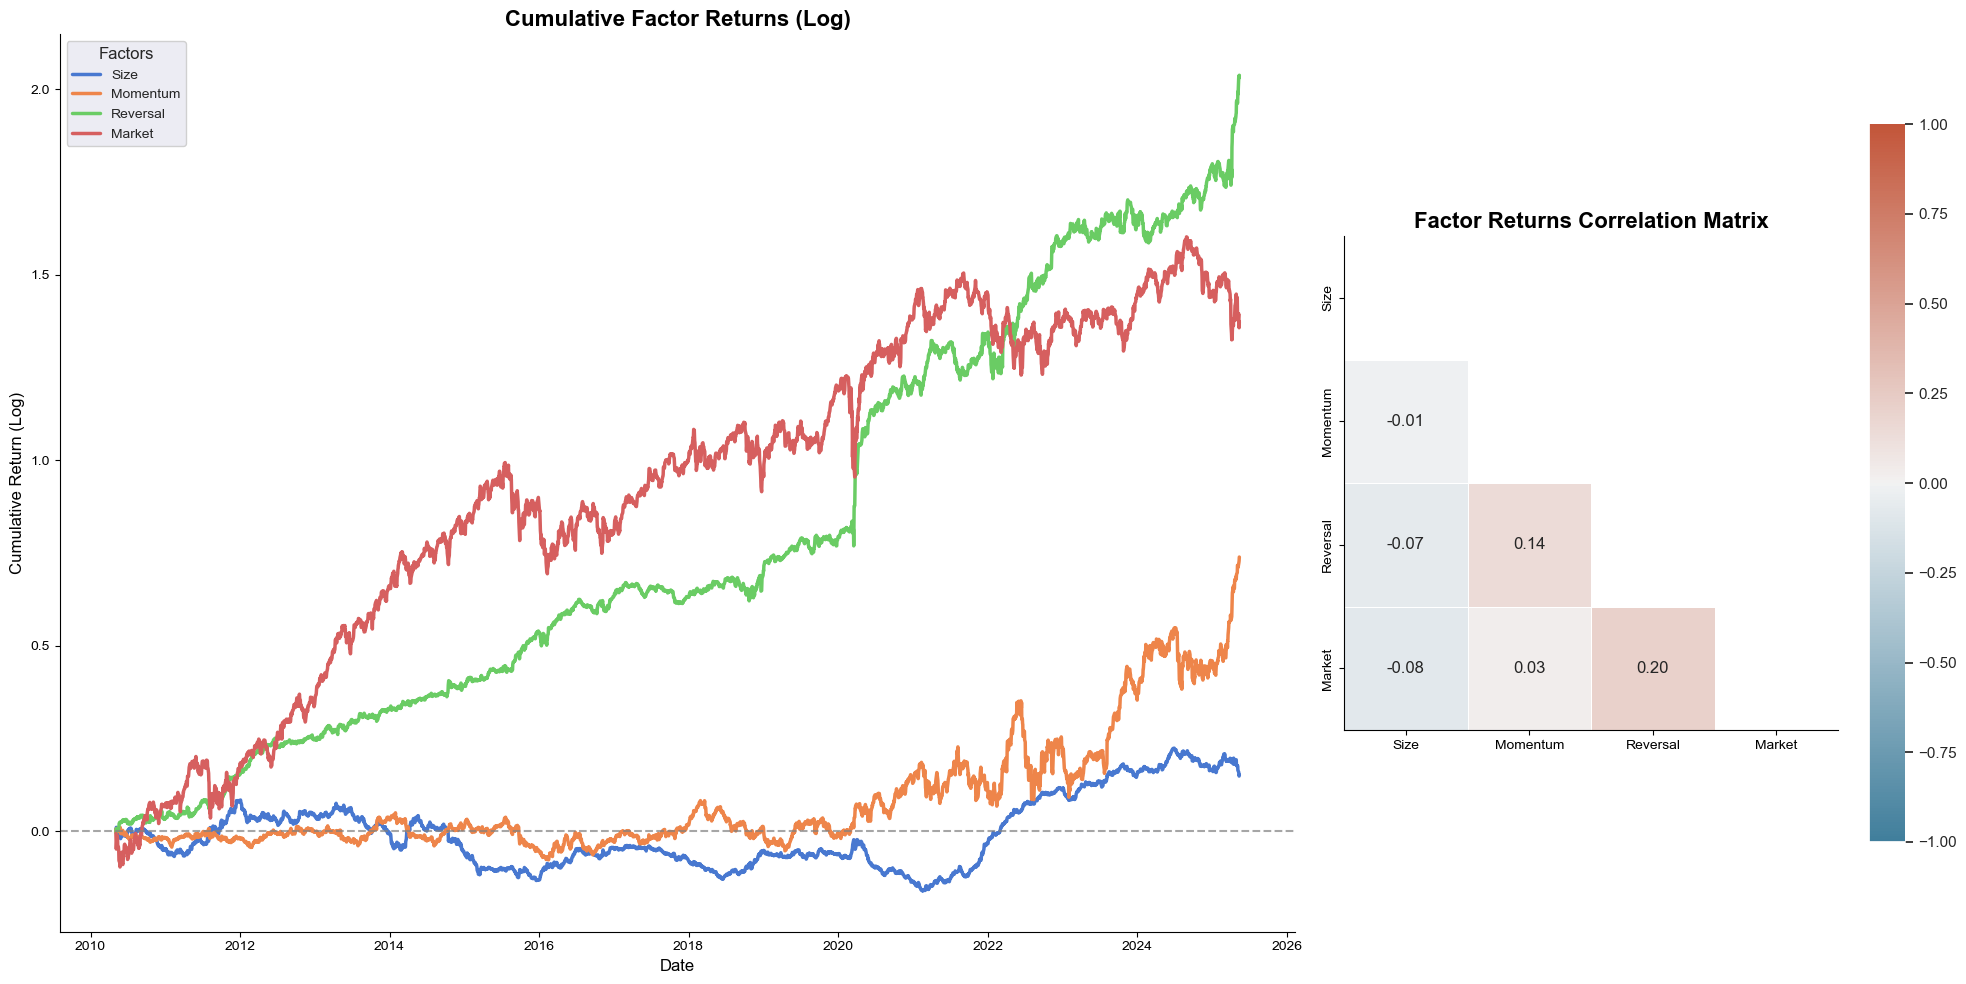

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

factor_rets_filtered = factor_rets.dropna(how='all')
factor_rets_clean = factor_rets_filtered.fillna(0)
cum_factor_rets = np.log(1 + factor_rets_clean).cumsum()

# Create a figure with side-by-side subplots
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Set the seaborn style
sns.set_theme(style="darkgrid")

# Plot 1: Cumulative Factor Returns
sns.lineplot(data=cum_factor_rets, dashes=False, linewidth=2.5, palette="muted", ax=ax1)

# Enhance the plot with better formatting
ax1.set_title('Cumulative Factor Returns (Log)', fontsize=16, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Cumulative Return (Log)', fontsize=12)
ax1.legend(title='Factors', title_fontsize=12, fontsize=10, frameon=True, framealpha=0.9)

# Add a zero line for reference
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

# Plot 2: Factor Return Correlations
corr_matrix = factor_rets_clean.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            annot=True, fmt=".2f", square=True, linewidths=.5, cbar_kws={"shrink": .8}, ax=ax2)

ax2.set_title('Factor Returns Correlation Matrix', fontsize=16, fontweight='bold')

# Format the plots
sns.despine(left=False, bottom=False)
plt.tight_layout()
plt.show()

In [172]:
ADD_COEF = 0  # amount to add deltas from quarter to quarter
OWNERSHIP_COEF = 0  # amount to add (ownership * weight) scaled port to existing port

# Create a dictionary to store fund performance for later reference
fund_performances = {}
fund_idio_returns = {}
fund_holdings = {}

quarter_ends = pd.date_range(
    start=pd.Timestamp('2014-12-31'),
    end=pd.Timestamp('2025-03-31'),
    freq='QE'  # Quarter end frequency (updated from 'Q')
)

calendar_quarter_total_returns = bt.get_period_returns(dates=quarter_ends).shift(-1)  # shift back one quarter to align with fund holdings
fund_list = bt.manager_df[~(bt.manager_df['Public_Start'].isna() | bt.manager_df['Public_End'].isna() | bt.manager_df['Not_Biotech'] | bt.manager_df['Contamination'])]['Master'].unique()

# Process each fund first
for fund in fund_list:

    #holdings = bt.get_fund_holdings(fund, contamination = bt.manager_df.loc[bt.manager_df['Master'] == fund, 'Contamination'].values[0])
    holdings = bt.get_fund_holdings(fund)
    holdings_mv = bt.get_fund_holdings(fund, normalize=False)

    holdings_dataset = bt.get_holdings_dataset(fund)

    holdings_chg = holdings_mv.mul(calendar_quarter_total_returns.reindex(index=holdings.index, columns=holdings.columns) + 1).shift(1).fillna(0)
    holdings_chg = holdings_chg.div(holdings_chg.sum(axis=1), axis=0).fillna(0)
    holdings_chg = holdings.sub(holdings_chg)

    holdings_ownership = holdings_mv.div(bt.sec_mkt_cap_df.reindex(index=holdings.index, columns=holdings.columns)).fillna(0)
    holdings_ownership = holdings_ownership.mul(holdings)
    holdings_ownership = holdings_ownership.div(holdings_ownership.sum(axis=1), axis=0).fillna(0)

    #holdings = holdings.add(OWNERSHIP_COEF*holdings_ownership)
    #holdings = holdings.add(ADD_COEF*holdings_chg).clip(lower=0)
    holdings = holdings.div(holdings.sum(axis=1), axis=0).fillna(0)

    holdings.index = holdings.index + pd.Timedelta(days=45)

    # Create mask for security criteria
    liquidity_mask = (bt.value_traded_df.reindex(index=holdings.index, columns=holdings.columns) >= 1000000)
    price_mask = (bt_data.sec_price_df.reindex(index=holdings.index, columns=holdings.columns) >= 1)
    mkt_cap_mask = (bt.sec_mkt_cap_df.reindex(index=holdings.index, columns=holdings.columns) <= 25000) & (bt.sec_mkt_cap_df.reindex(index=holdings.index, columns=holdings.columns) > 100)
    combined_mask = liquidity_mask & price_mask & mkt_cap_mask
    
    holdings = holdings.mul(combined_mask).fillna(0)

    fund_holdings[fund] = holdings
    
    #holdings = bt.adjust_holdings(holdings, max_participation=0.2, port_size=10000000)
    
    if len(holdings) == 0:
        print(f"{fund} has no holdings")
        continue
    
    perf, ctr, weights_df = bt.get_strategy_returns(holdings, max(holdings.index) + pd.Timedelta(days=90))
    attr = bt.get_factor_attribution(weights_df, factor_scores, factor_rets, max(holdings.index) + pd.Timedelta(days=90))

    # Store just the performance in the dictionary
    fund_performances[fund] = perf
    fund_idio_returns[fund] = attr['Idio']

In [173]:
# Calculate returns for different periods
def calculate_returns(perf_series, last_date, fund_name=None):
    """Calculate annualized returns for different periods"""
    cum_perf = (1 + perf_series.fillna(0)).cumprod()
    
    periods = {
        '1Y Return': last_date - pd.Timedelta(days=365),
        '3Y Return': last_date - pd.Timedelta(days=365*3),
        '5Y Return': last_date - pd.Timedelta(days=365*5)
    }
    
    returns = {}
    
    # Calculate returns for each period
    for period_name, start_date in periods.items():
        if cum_perf.index[0] <= start_date:
            start_val = cum_perf[cum_perf.index >= start_date].iloc[0]
            end_val = cum_perf.iloc[-1]
            days = (last_date - cum_perf[cum_perf.index >= start_date].index[0]).days
            returns[period_name] = (end_val / start_val) ** (365.25 / days) - 1
        else:
            returns[period_name] = np.nan
    
    # Since Inception return
    if fund_name == 'XBI US':
        # For XBI, start at 45 days after 12/31/2014
        inception_date = pd.Timestamp('2014-12-31') + pd.Timedelta(days=45)
        start_val = cum_perf[cum_perf.index >= inception_date].iloc[0]
        days = (last_date - inception_date).days
    else:
        start_val = cum_perf.iloc[0]
        days = (last_date - cum_perf.index[0]).days
    
    end_val = cum_perf.iloc[-1]
    returns['SI Return'] = (end_val / start_val) ** (365.25 / days) - 1
    
    return returns

results = []

# Add XBI US performance
xbi_perf = bt.sec_rets_df['XBI US']
xbi_last_date = xbi_perf.index[-1]
xbi_returns = calculate_returns(xbi_perf, xbi_last_date)

results.append({
    'Fund': 'XBI US',
    'Last Date': xbi_last_date,
    **xbi_returns
})

# Add fund performances
for fund in fund_performances:
    perf = fund_performances[fund]
    last_date = perf.index[-1]
    fund_returns = calculate_returns(perf, last_date)
    
    results.append({
        'Fund': fund,
        'Last Date': last_date,
        **fund_returns
    })

# Create DataFrame and sort by 3Y returns
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('3Y Return', ascending=False)

# Format the returns as percentages
for col in ['1Y Return', '3Y Return', '5Y Return', 'SI Return']:
    results_df[col] = results_df[col].map(lambda x: f'{x:.1%}' if not pd.isna(x) else 'N/A')

# Display the table
display(results_df)

,Fund,Last Date,1Y Return,3Y Return,5Y Return,SI Return
3,Affinity,2025-05-15,-18.1%,31.8%,N/A,-1.6%
22,Darwin Global,2025-05-15,-20.1%,27.7%,N/A,2.0%
52,Tri Locum,2025-05-15,2.8%,23.2%,N/A,1.2%
49,Sofinnova,2025-05-15,-31.3%,20.9%,1.4%,10.6%
19,Cormorant,2025-05-15,-27.2%,20.1%,-7.3%,2.4%
26,Eversept,2025-05-15,-11.7%,20.0%,11.9%,10.9%
33,Kynam,2025-05-15,-20.2%,19.6%,N/A,12.3%
45,Samsara,2025-05-15,-23.5%,18.6%,-8.7%,-1.3%
17,Clough,2025-05-15,-29.8%,17.4%,0.5%,0.8%
27,First Light,2025-05-15,-27.1%,16.8%,13.4%,13.3%


In [174]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

HALF_LIFE = 3*365

xbi = bt.sec_rets_df['XBI US'].loc[pd.Timestamp('2014-12-31'):pd.Timestamp('2025-05-15')]
lsbp = bt.sec_rets_df['LSCIBP'].loc[pd.Timestamp('2014-12-31'):pd.Timestamp('2025-05-15')]
lsbc = bt.sec_rets_df['LSCIBC'].loc[pd.Timestamp('2014-12-31'):pd.Timestamp('2025-05-15')]

quarter_ends = pd.date_range(
    start=pd.Timestamp('2014-12-31'),
    end=pd.Timestamp('2025-03-31'),
    freq='QE'  # Quarter end frequency (updated from 'Q')
)
quarter_ends_delayed = [date + pd.Timedelta(days=45) for date in quarter_ends]

# Create a DataFrame to store all IR values
all_ir_data = []

for date in quarter_ends_delayed:
    for fund in fund_performances:
        if date - pd.Timedelta(days=365) not in fund_performances[fund].index or (date > max(fund_performances[fund].index)):
            continue

        cur_fund_perf = fund_performances[fund].loc[:date]
        xbi_perf = xbi.loc[cur_fund_perf.index]
        lsbp_perf = lsbp.loc[cur_fund_perf.index]
        lsbc_perf = lsbc.loc[cur_fund_perf.index]
        # Join XBI performance to fund performance
        combined_perf = pd.DataFrame({
            'fund': cur_fund_perf,
            'xbi': xbi_perf,
            'lsbp': lsbp_perf,
            'lsbc': lsbc_perf
        })
        # Drop rows where either fund or XBI performance is exactly 0
        combined_perf = combined_perf[(combined_perf['fund'] != 0) & (combined_perf['xbi'] != 0) & (combined_perf['lsbp'] != 0) & (combined_perf['lsbc'] != 0)]
        # Calculate exponential weights with a half-life of 255 days
        days_diff = (date - combined_perf.index).days
        combined_perf['Weight'] = np.exp(-np.log(2) * days_diff / HALF_LIFE)

        try:
            X = sm.add_constant(combined_perf[['lsbp', 'lsbc']])
            model = sm.WLS(combined_perf['fund'], X, weights=combined_perf['Weight'])
            results = model.fit()
        except:
            print(f"Error fitting model for {fund} on {date}")
            continue

        daily_vol = np.sqrt(np.sum(combined_perf['Weight'] * results.resid**2)/np.sum(combined_perf['Weight']))
        daily_alpha = np.sum(results.resid * combined_perf['Weight'])/np.sum(combined_perf['Weight']) + results.params.iloc[0]
        
        # Calculate t-stat for regression alpha
        alpha_se = results.bse.iloc[0]  # Standard error of the intercept (alpha)
        regression_t_stat = results.params.iloc[0] / alpha_se

        idio_perf = fund_idio_returns[fund].loc[cur_fund_perf.index]
        weighted_idio_alpha = np.sum(idio_perf * combined_perf['Weight'])/np.sum(combined_perf['Weight'])
        weighted_idio_vol = np.sqrt(np.sum((idio_perf-weighted_idio_alpha)**2 * combined_perf['Weight'])/np.sum(combined_perf['Weight']))
        
        # Calculate t-stat for idio alpha
        # Standard error of weighted mean
        idio_alpha_se = weighted_idio_vol / np.sqrt(np.sum(combined_perf['Weight']))
        idio_t_stat = weighted_idio_alpha / idio_alpha_se
        
        # Add to our list of IR data
        all_ir_data.append({
            'half_life': HALF_LIFE,
            'date': date,
            'fund': fund,
            'regression_ir': daily_alpha/daily_vol * np.sqrt(252),
            'regression_alpha': daily_alpha * 252,
            'regression_t_stat': regression_t_stat,
            'idio_alpha': weighted_idio_alpha * 252,
            'idio_ir': weighted_idio_alpha/weighted_idio_vol * np.sqrt(252),
            'idio_t_stat': idio_t_stat
        })

# Convert the list to a DataFrame
ir_df = pd.DataFrame(all_ir_data)
ir_df.to_clipboard()

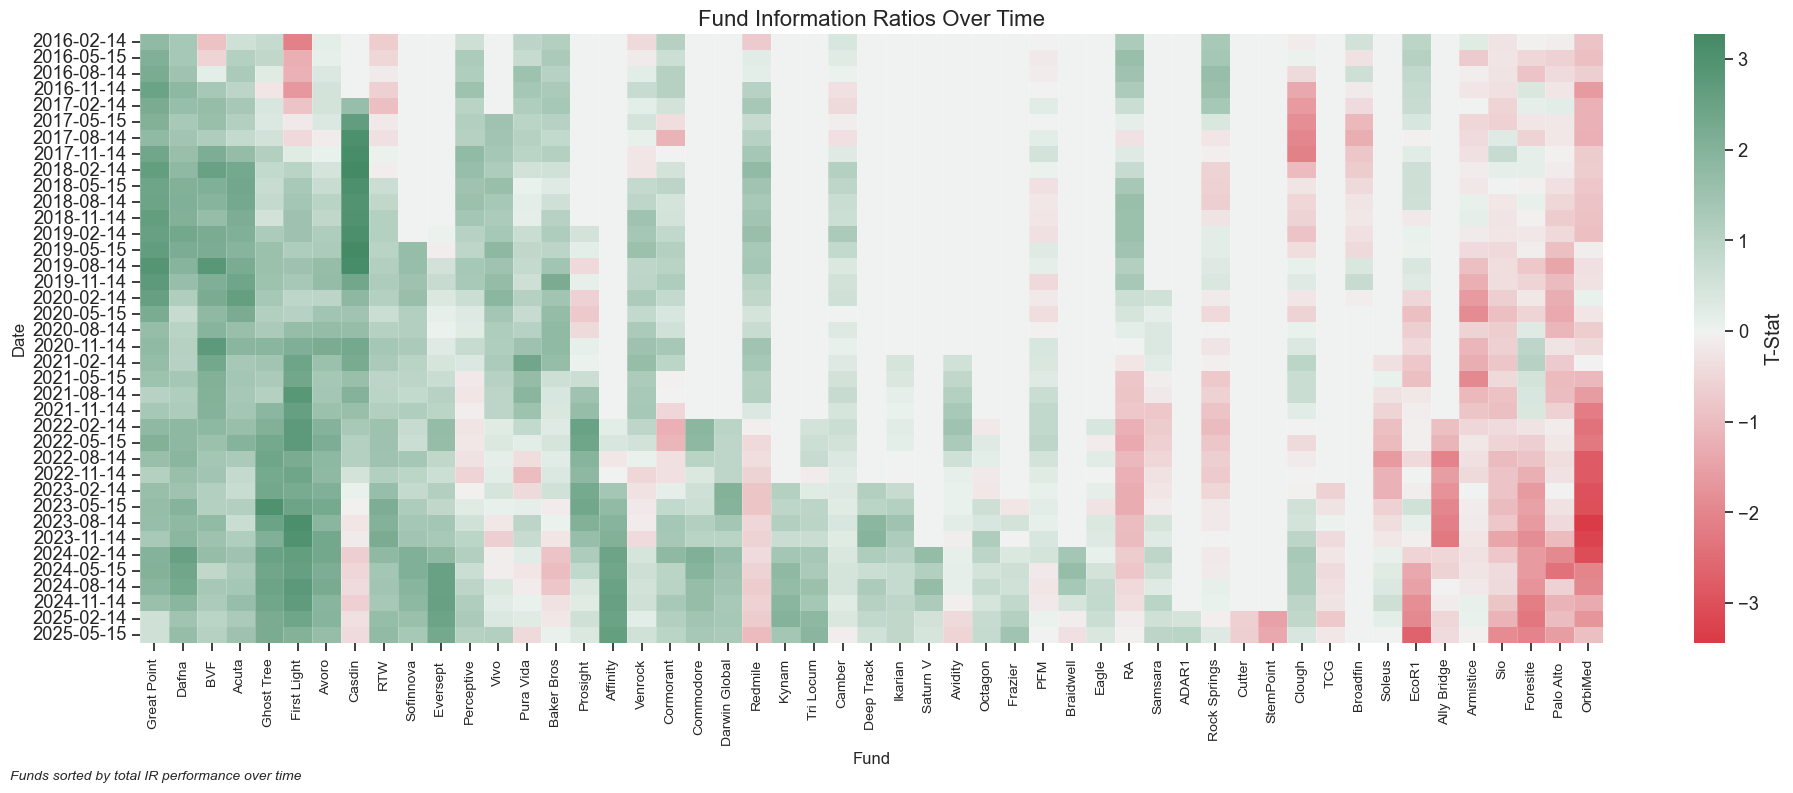

In [175]:
# Create a pivot table for IR values over time
ir_pivot = ir_df.pivot(index='date', columns='fund', values='regression_t_stat')
ir_pivot = ir_pivot.fillna(0)

# Calculate the sum of IR values over all time for each fund
fund_ir_sums = ir_pivot.sum()

# Sort funds by their total IR sum over all time
sorted_funds = fund_ir_sums.sort_values(ascending=False).index
ir_pivot = ir_pivot[sorted_funds]

# Create a diverging colormap centered at 0 with green for positive and red for negative
custom_cmap = sns.diverging_palette(10, 145, as_cmap=True)  # Green for positive, red for negative

# Plot - IR values with increased width to show all funds
plt.figure(figsize=(20, 8))  # Increased width to show all funds
ax1 = sns.heatmap(ir_pivot, cmap=custom_cmap, center=0, cbar_kws={'label': 'T-Stat'})

plt.title('Fund Information Ratios Over Time', fontsize=16)
plt.xlabel('Fund', fontsize=12)
plt.ylabel('Date', fontsize=12)

# Rotate x-axis labels for better readability and ensure all are visible
plt.xticks(rotation=90, fontsize=10)
plt.tick_params(axis='x', which='major', pad=5)  # Add padding for x-axis labels

# Format dates on y-axis
date_format = plt.matplotlib.dates.DateFormatter('%Y-%m-%d')
ax1.yaxis.set_major_formatter(date_format)

# Fix the yticks issue by getting the correct number of ticks
y_locs = np.arange(len(ir_pivot.index)) + 0.5  # Center of each cell
y_labels = [d.strftime('%Y-%m-%d') for d in ir_pivot.index]
plt.yticks(y_locs, y_labels)

# Add grid lines to make it easier to track across the chart
ax1.grid(False)  # Turn off the default grid
for i in range(len(sorted_funds)):
    plt.axvline(x=i, color='white', linewidth=0.5, alpha=0.3)

# Add a descriptive annotation
plt.figtext(0.01, 0.01, "Funds sorted by total IR performance over time", 
            fontsize=10, style='italic')

# Ensure all labels are visible
plt.tight_layout()
plt.show()

In [ ]:
# EMA-based scoring system
fund_scores = {}  # Track fund EMA scores

for i, date in enumerate(sorted(ir_df['date'].unique())):
    date_mask = ir_df['date'] == date
    
    # Get all funds for this date
    eligible_data = ir_df.loc[date_mask]
    
    # Calculate percentile ranks for regression_t_stat for all funds
    if len(eligible_data) > 0:
        percentiles = eligible_data['regression_t_stat'].rank(pct=True)
    else:
        percentiles = pd.Series()
    
    # Initialize all weights to 0
    ir_df.loc[date_mask, 'weight'] = 0
    
    if i == 0:  # First quarter - initialize scores with current percentiles
        for fund in ir_df.loc[date_mask, 'fund']:
            fund_percentile = percentiles[eligible_data['fund'] == fund].iloc[0] if fund in eligible_data['fund'].values else 0.5
            fund_scores[fund] = fund_percentile
    else:
        # Update fund scores using EMA: current score = 0.25*current percentile + 0.75*previous score
        for fund in ir_df.loc[date_mask, 'fund']:
            current_percentile = percentiles[eligible_data['fund'] == fund].iloc[0] if fund in eligible_data['fund'].values else 0.5
            previous_score = fund_scores.get(fund, 0.5)
            fund_scores[fund] = 0.25 * current_percentile + 0.75 * previous_score
    
    # Calculate weights based on score - 0.5
    total_weight = 0
    fund_weights = {}
    
    for fund in ir_df.loc[date_mask, 'fund']:
        if fund_scores[fund] < 0.5:
            weight = 0
        else:
            weight = fund_scores[fund] - 0.5
        fund_weights[fund] = weight
        total_weight += weight
    
    # Normalize weights to sum to 1
    if total_weight > 0:
        for fund in fund_weights:
            fund_mask = (date_mask) & (ir_df['fund'] == fund)
            ir_df.loc[fund_mask, 'weight'] = fund_weights[fund] / total_weight


# Create a blank DataFrame with all securities from sec_rets_df and all dates from ir_df
all_dates = ir_df['date'].unique()
all_securities = bt.sec_rets_df.columns.tolist()
final_holdings = pd.DataFrame(0.0, index=all_dates, columns=all_securities)

for date in all_dates:
    # Get the funds and their weights for that date
    funds_on_date = ir_df[ir_df['date'] == date]
    for fund, weight in zip(funds_on_date['fund'], funds_on_date['weight']):
        # Only add values for columns that exist in both DataFrames
        try:
            columns = fund_holdings[fund].columns
            #final_holdings.loc[date, columns] += (fund_holdings[fund].loc[date - pd.Timedelta(days=45), columns])*weight
            final_holdings.loc[date, columns] += (fund_holdings[fund].loc[date, columns])*weight
        except KeyError:
            print(f"Skipping {fund} for date {date} - no holdings data available")
            continue

final_holdings[final_holdings < 0] = 0

# Renormalize by dividing each row by its sum
row_sums = final_holdings.sum(axis=1)
final_holdings = final_holdings.div(row_sums, axis=0)

final_holdings = bt.adjust_holdings(final_holdings, max_participation=0.2, port_size=100000000, n=100)

In [201]:
# Get the holdings for the specified date
holdings = final_holdings.loc[pd.Timestamp('2025-05-15')].dropna().loc[lambda x: x != 0]

# Create detailed breakdown table for the last date
last_date = sorted(all_dates)[-1]
funds_on_last_date = ir_df[ir_df['date'] == last_date]

# Create a DataFrame with funds as rows and tickers as columns
fund_contribution_table = pd.DataFrame(0.0, 
                                     index=funds_on_last_date['fund'].tolist(), 
                                     columns=all_securities)

for fund, weight in zip(funds_on_last_date['fund'], funds_on_last_date['weight']):
    try:
        columns = fund_holdings[fund].columns
        fund_contribution_table.loc[fund, columns] = (fund_holdings[fund].loc[last_date, columns]) * weight
    except KeyError:
        print(f"Skipping {fund} for date {last_date} - no holdings data available")
        continue

# Remove columns that are all zeros for cleaner display
fund_contribution_table = fund_contribution_table.loc[:, (fund_contribution_table != 0).any(axis=0)]

# Create a table with ticker and comma-separated manager names sorted by contribution
ticker_managers = []

for ticker in fund_contribution_table.columns:
    # Get all funds that own this ticker and their contributions
    ticker_data = fund_contribution_table[ticker]
    ticker_data = ticker_data[ticker_data > 0]  # Only include non-zero holdings
    
    # Sort by contribution (descending) to get managers in order of contribution
    sorted_managers = ticker_data.sort_values(ascending=False)
    
    # Create comma-separated list of manager names with stripped whitespace
    manager_list = ', '.join([manager.strip() for manager in sorted_managers.index.tolist()])
    
    # Create row with ticker and manager list
    ticker_managers.append({
        'Ticker': ticker,
        'Managers': manager_list
    })

# Convert to DataFrame
top_contributors_table = pd.DataFrame(ticker_managers)

# Create holdings DataFrame with current holdings
current_holdings_df = pd.DataFrame({
    'Ticker': holdings.index,
    'Weight': holdings.values
})

# Left join the ticker managers onto the current holdings
top_contributors_table = current_holdings_df.merge(top_contributors_table, on='Ticker', how='left')

# Sort by weight (descending)
top_contributors_table = top_contributors_table.sort_values('Weight', ascending=False)

# Reset index for clean display
top_contributors_table = top_contributors_table.reset_index(drop=True)

In [202]:
top_contributors_table.to_clipboard()

,Ticker,Weight,Managers
0,INSM US,0.063136,"Darwin Global, Acuta, Tri Locum, RTW, Ghost Tr..."
1,NTRA US,0.044645,"Eversept, Sofinnova, Kynam, RTW, ADAR1"
2,MRUS US,0.029574,"Commodore, Dafna, Tri Locum, Great Point, Affi..."
3,ASND US,0.027964,"Avoro, Dafna, Ghost Tree, Saturn V, Acuta, Tri..."
4,VERA US,0.027707,"First Light, Eversept, Sofinnova, Kynam, Commo..."
5,MDGL US,0.026800,"Avoro, RTW, Tri Locum, Affinity, Perceptive, A..."
6,MLTX US,0.026613,"BVF, Cormorant, Ghost Tree, Avoro, Saturn V, O..."
7,SLNO US,0.025375,"Tri Locum, Ghost Tree, Commodore, Acuta, Avoro..."
8,XENE US,0.025200,"Affinity, First Light, Commodore, Dafna, Avoro..."
9,VRNA US,0.024918,"Darwin Global, Affinity, Perceptive, RTW, Fraz..."


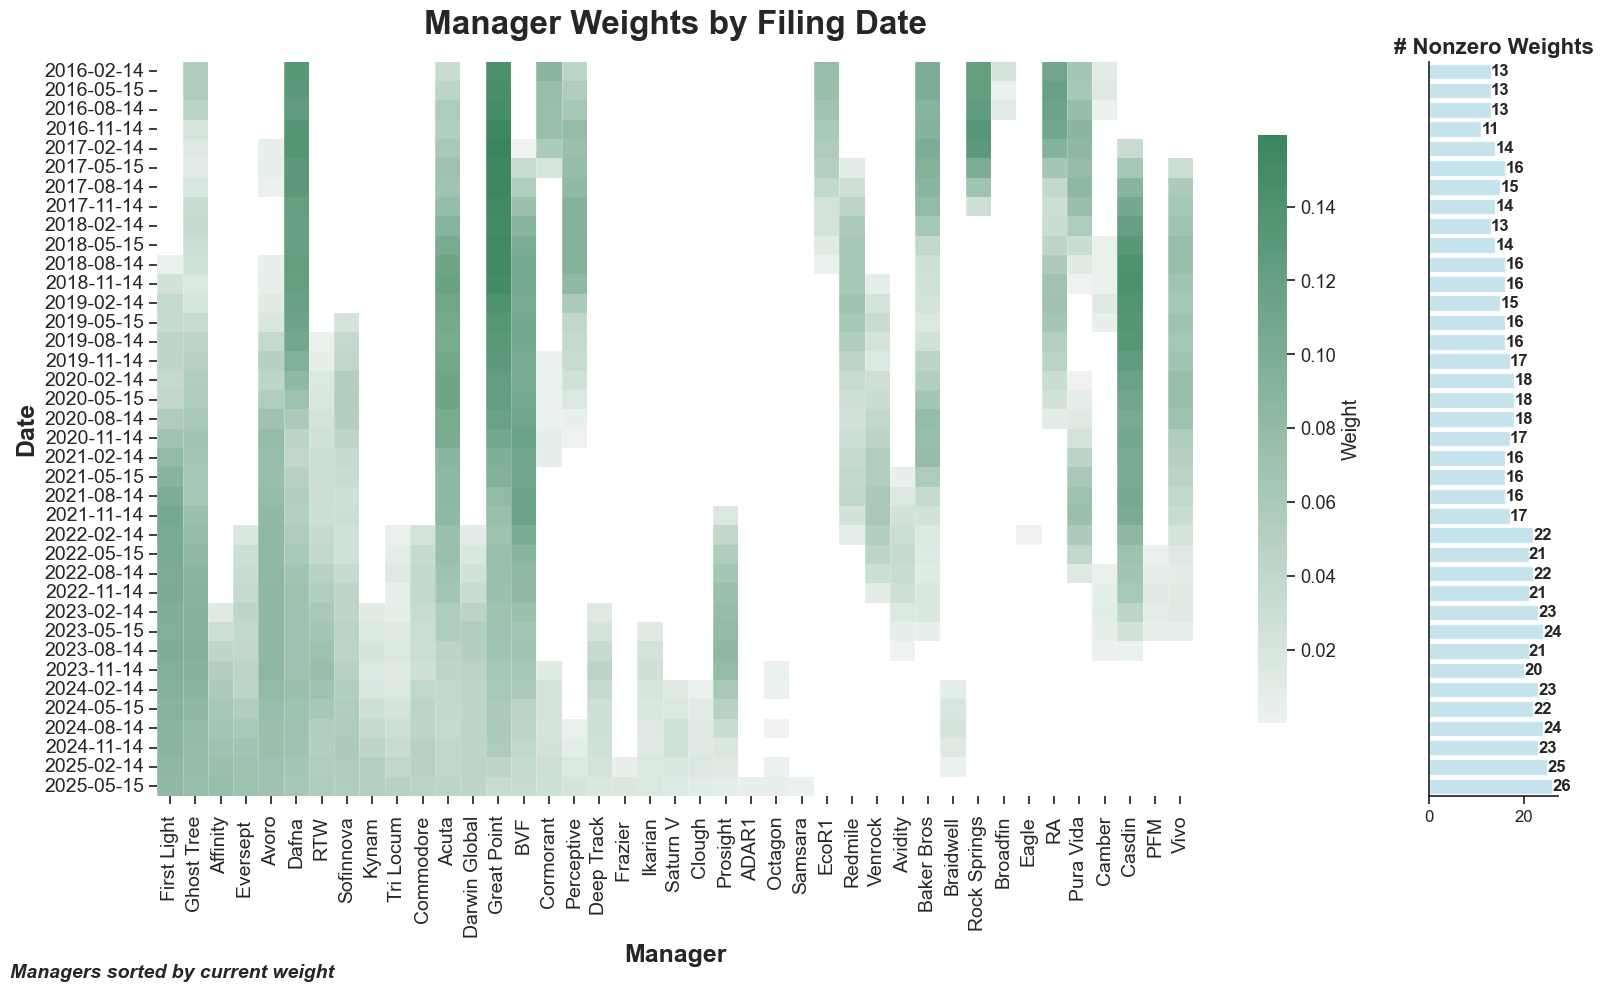

In [180]:
weight_pivot = ir_df.pivot(index='date', columns='fund', values='weight')
# Replace zeros with NaN for better visualization
weight_pivot = weight_pivot.replace(0, np.nan)

# Only include funds that have weight > 0 at some point
funds_with_weight = weight_pivot.columns[weight_pivot.max() > 0]
weight_pivot = weight_pivot[funds_with_weight]

# Get the most recent date's weights and sort funds by current weight
most_recent_date = weight_pivot.index.max()
current_weights = weight_pivot.loc[most_recent_date].fillna(0)

# Sort funds by their current weight (most recent date)
sorted_funds = current_weights.sort_values(ascending=False).index
weight_pivot = weight_pivot[sorted_funds]

# Calculate number of managers (non-NaN values) for each date
managers_per_date = weight_pivot.count(axis=1)

# Create a diverging colormap centered at 0 with green for positive and red for negative
custom_cmap = sns.diverging_palette(10, 145, as_cmap=True)  # Changed order to make green positive

# Plot - Formatted for PowerPoint with taller aspect ratio
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10), gridspec_kw={'width_ratios': [20, 2]})  # Much taller for PowerPoint

# Main heatmap
sns.heatmap(weight_pivot, cmap=custom_cmap, center=0, cbar_kws={'label': 'Weight', 'shrink': 0.8}, ax=ax1)

ax1.set_title('Manager Weights by Filing Date', fontsize=24, fontweight='bold', pad=20)
ax1.set_xlabel('Manager', fontsize=18, fontweight='bold')
ax1.set_ylabel('Date', fontsize=18, fontweight='bold')

# Rotate x-axis labels for better readability and ensure all are visible with larger font
ax1.tick_params(axis='x', rotation=90, labelsize=14, pad=8)
ax1.tick_params(axis='y', labelsize=14)

# Format dates on y-axis
y_locs = np.arange(len(weight_pivot.index)) + 0.5  # Center of each cell
y_labels = [d.strftime('%Y-%m-%d') for d in weight_pivot.index]
ax1.set_yticks(y_locs)
ax1.set_yticklabels(y_labels)

# Add grid lines to make it easier to track across the chart
ax1.grid(False)  # Turn off the default grid
for i in range(len(sorted_funds)):
    ax1.axvline(x=i, color='white', linewidth=0.5, alpha=0.3)

# Side plot showing number of managers per date
ax2.barh(y_locs, managers_per_date.values, height=0.8, color='lightblue', alpha=0.7)
ax2.set_ylim(ax1.get_ylim())
ax2.set_xlabel('', fontsize=16, fontweight='bold')
ax2.set_title('# Nonzero Weights', fontsize=16, fontweight='bold')
ax2.set_yticks([])  # Remove y-axis labels since they're already on the main plot
ax2.tick_params(axis='x', labelsize=12)

# Add value labels on the bars with larger font
for i, v in enumerate(managers_per_date.values):
    ax2.text(v + 0.1, y_locs[i], str(v), va='center', fontsize=12, fontweight='bold')

# Add a descriptive annotation with larger font
fig.text(0.01, 0.01, "Managers sorted by current weight", 
         fontsize=14, style='italic', fontweight='bold')

# Ensure all labels are visible
plt.tight_layout()
plt.show()


In [91]:
returns, ctr, weights = bt.get_strategy_returns(final_holdings, end_date = pd.Timestamp('2025-05-15'))
returns.to_clipboard()

In [39]:
# Convert final_holdings to long format with Ticker column and filter out non-positive weights
final_holdings_long = final_holdings.reset_index().melt(
    id_vars='index',
    var_name='Ticker',
    value_name='Weight'
).query('Weight > 0').sort_values(['index', 'Weight'], ascending=[True, False])  # Sort by date then by weight descending

# Copy to clipboard
final_holdings_long.to_clipboard()


In [58]:
start_date = pd.Timestamp('2025-05-11') 
end_date = start_date

init_weight = weights.loc[start_date][weights.loc[start_date] > 0]

tickers = init_weight.index.values

returns = bt.sec_rets_df[tickers].loc[start_date:end_date]
returns = (1 + returns).prod() - 1

# Create DataFrame with ticker as index and required columns
result_df = pd.DataFrame({
    'Starting Weight': init_weight,
    'Return': returns,
    'Contribution': init_weight * returns
})

# Sort by contribution
result_df = result_df.sort_values('Contribution', ascending=False)

result_df.to_clipboard()


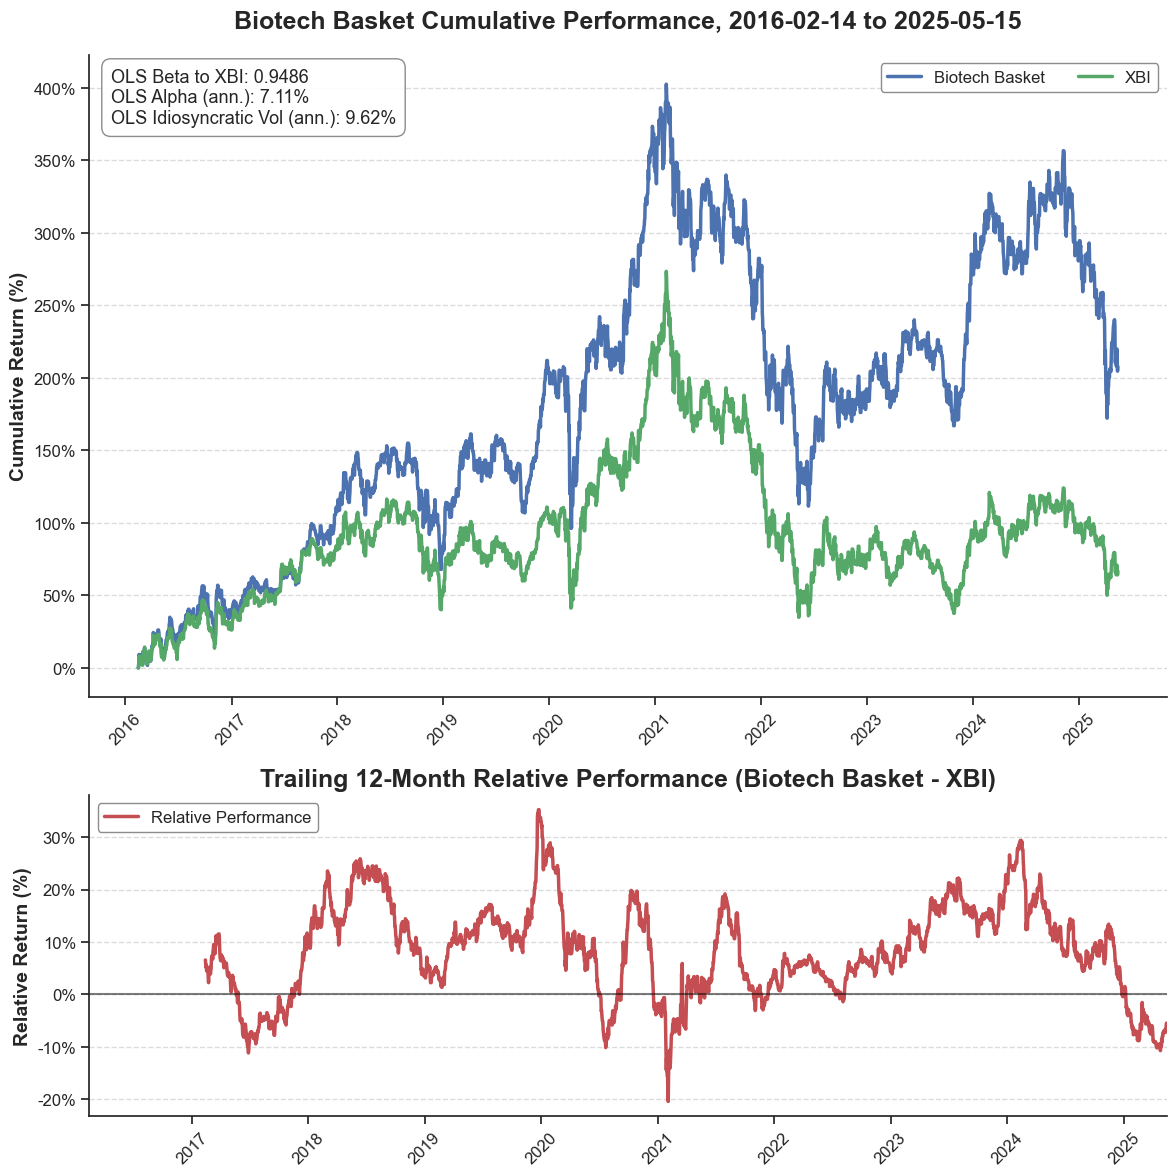

In [181]:
# Get strategy returns and XBI returns
strategy_returns, ctr, _ = bt.get_strategy_returns(final_holdings, pd.Timestamp('2025-05-15'))
xbi_returns = bt.sec_rets_df['XBI US'].loc[strategy_returns.index[0]:strategy_returns.index[-1]]

# Convert to cumulative returns
strategy_cumulative = (1 + strategy_returns).cumprod() - 1
xbi_cumulative = (1 + xbi_returns).cumprod() - 1

# Create a DataFrame for plotting
cumulative_returns = pd.DataFrame({
    'Biotech Basket': strategy_cumulative,
    'XBI': xbi_cumulative
})

# Calculate trailing 12-month cumulative returns for both strategy and XBI
strategy_t12m = (1 + strategy_returns).rolling(window=365).apply(lambda x: x.prod()) - 1
xbi_t12m = (1 + xbi_returns).rolling(window=365).apply(lambda x: x.prod()) - 1

# Calculate trailing 12-month relative performance (Strategy T12M - XBI T12M)
trailing_12m_relative = strategy_t12m - xbi_t12m
# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [2, 1]})

# Compute beta and alpha to XBI for regular strategy
returns_for_regression = pd.DataFrame({
    'strategy': strategy_returns,
    'xbi': xbi_returns
})
returns_for_regression = returns_for_regression.dropna()
returns_for_regression = returns_for_regression[(returns_for_regression['strategy'] != 0) | 
                                               (returns_for_regression['xbi'] != 0)]

# Add a constant to the regression model
X = sm.add_constant(returns_for_regression['xbi'])
Y = returns_for_regression['strategy']

# Fit the regression model
model = sm.OLS(Y, X).fit()
# Extract beta and alpha
beta = model.params['xbi']
alpha = model.params['const']
alpha_annualized = alpha * len(returns_for_regression) / ((strategy_returns.index[-1] - strategy_returns.index[0]).days / 365.25)

idio_vol = model.resid.std()
idio_vol_annualized = idio_vol * np.sqrt(len(returns_for_regression) / ((strategy_returns.index[-1] - strategy_returns.index[0]).days / 365.25))
# Set a professional theme and color palette
sns.set_theme(style="ticks", palette="colorblind", font="Arial", font_scale=1.2)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Plot 1: Cumulative Performance
colors = ["#4C72B0", "#55A868"]  # Different professional colors
ax1.grid(True, linestyle='--', alpha=0.7, axis='y')
sns.lineplot(data=cumulative_returns, ax=ax1, linewidth=2.5, palette=colors, dashes=False)

# Format the plot
ax1.set_title(f"Biotech Basket Cumulative Performance, {cumulative_returns.index.min().strftime('%Y-%m-%d')} to {cumulative_returns.index.max().strftime('%Y-%m-%d')}", fontsize=18, fontweight='bold', pad=20)
ax1.set_ylabel("Cumulative Return (%)", fontsize=14, fontweight='bold')
ax1.set_xlabel("")  # Remove x-axis label
ax1.tick_params(axis='both', labelsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))

# Enhance legend
legend = ax1.legend(title="", loc='upper right', ncol=2, frameon=True, framealpha=0.9, 
                   fontsize=12, edgecolor='gray')
legend.get_frame().set_linewidth(1)

# Add metrics box with enhanced styling
metrics_text = (
    f"OLS Beta to XBI: {beta:.4f}\n"
    f"OLS Alpha (ann.): {alpha_annualized*100:.2f}%\n"
    f"OLS Idiosyncratic Vol (ann.): {idio_vol_annualized*100:.2f}%"
)

ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, fontsize=13,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
                                          facecolor='white', 
                                          edgecolor='gray', 
                                          alpha=0.9,
                                          linewidth=1))

# Plot 2: Trailing 12-month Relative Performance
ax2.grid(True, linestyle='--', alpha=0.7, axis='y')
sns.lineplot(data=trailing_12m_relative, color="#C44E52", 
            ax=ax2, linewidth=2.5, label='Relative Performance')

# Format the second plot
ax2.set_title("Trailing 12-Month Relative Performance (Biotech Basket - XBI)", 
             fontsize=18, fontweight='bold')
ax2.set_ylabel("Relative Return (%)", fontsize=14, fontweight='bold')
ax2.set_xlabel("")  # Remove x-axis label
ax2.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1.5)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))

# Add legend for the second plot
ax2.legend(title="", loc='upper left', ncol=1, frameon=True, framealpha=0.9, 
          fontsize=12, edgecolor='gray')

# Ensure both plots have the same x-axis range
ax2.set_xlim(cumulative_returns.index.min(), cumulative_returns.index.max())

plt.tight_layout()
plt.show()


In [183]:
strategy_cumulative.to_clipboard()

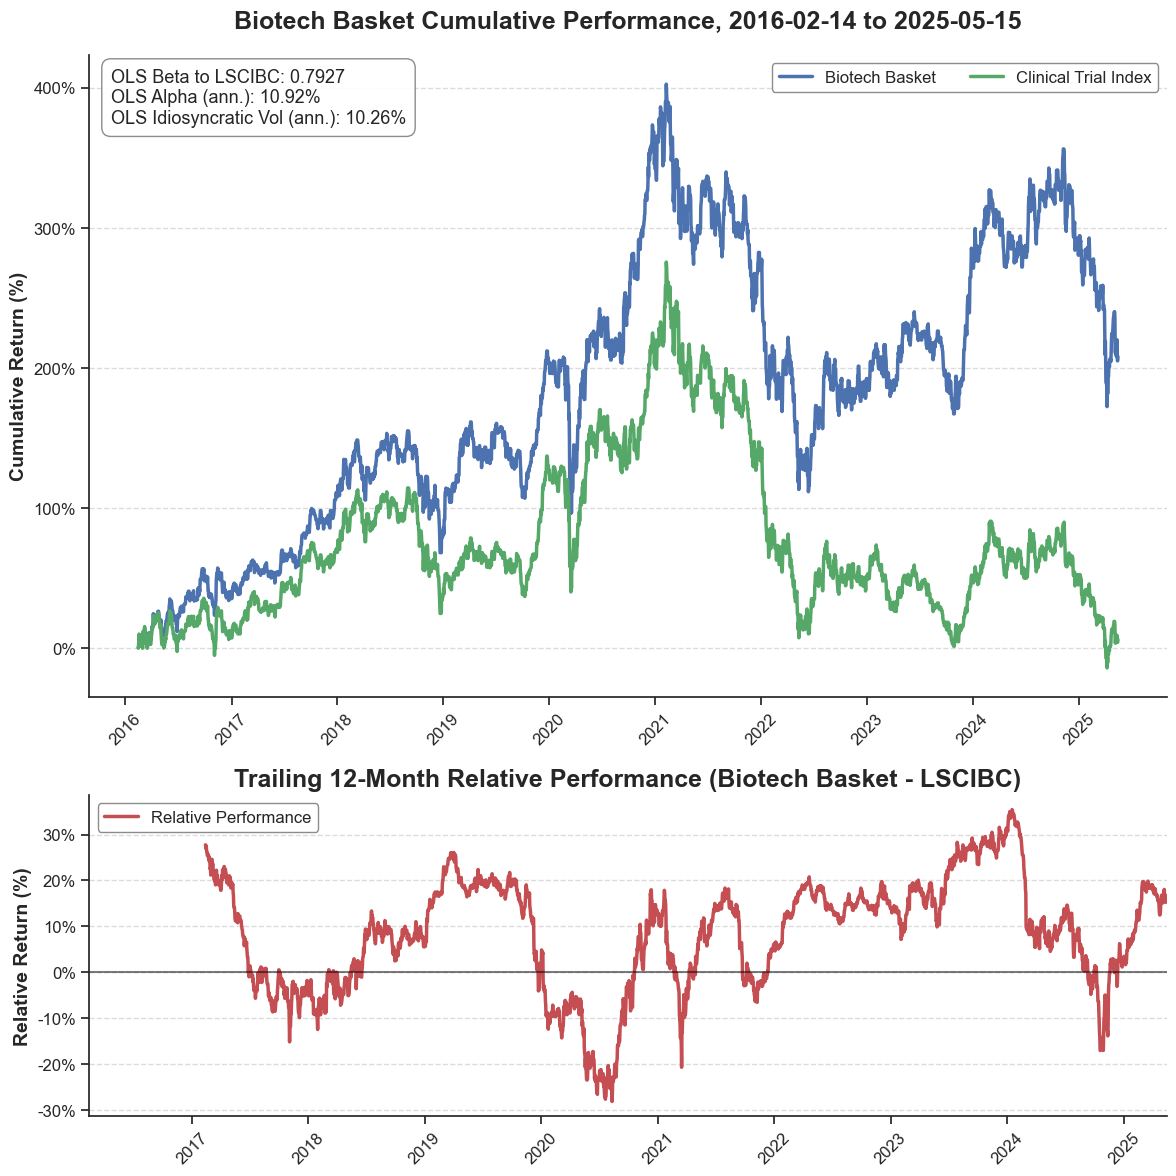

In [135]:
# Get strategy returns and LSCIBreturns
strategy_returns, ctr, weights = bt.get_strategy_returns(final_holdings, pd.Timestamp('2025-05-15'))
clinical_trial_index_returns = bt.sec_rets_df['LSCIBC'].loc[strategy_returns.index[0]:strategy_returns.index[-1]]

# Convert to cumulative returns
strategy_cumulative = (1 + strategy_returns).cumprod() - 1
clinical_trial_index_cumulative = (1 + clinical_trial_index_returns).cumprod() - 1

# Create a DataFrame for plotting
cumulative_returns = pd.DataFrame({
    'Biotech Basket': strategy_cumulative,
    'Clinical Trial Index': clinical_trial_index_cumulative
})

# Calculate trailing 12-month cumulative returns for both strategy and Clinical Trial Index
strategy_t12m = (1 + strategy_returns).rolling(window=365).apply(lambda x: x.prod()) - 1
clinical_trial_index_t12m = (1 + clinical_trial_index_returns).rolling(window=365).apply(lambda x: x.prod()) - 1

# Calculate trailing 12-month relative performance (Strategy T12M - Clinical Trial Index T12M)
trailing_12m_relative = strategy_t12m - clinical_trial_index_t12m

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [2, 1]})

# Compute beta and alpha to LSCIB for regular strategy
returns_for_regression = pd.DataFrame({
    'strategy': strategy_returns,
    'lscibc': clinical_trial_index_returns
})
returns_for_regression = returns_for_regression.dropna()
returns_for_regression = returns_for_regression[(returns_for_regression['strategy'] != 0) | 
                                               (returns_for_regression['lscibc'] != 0)]

# Add a constant to the regression model
X = sm.add_constant(returns_for_regression['lscibc'])
Y = returns_for_regression['strategy']

# Fit the regression model
model = sm.OLS(Y, X).fit()
# Extract beta and alpha
beta = model.params['lscibc']
alpha = model.params['const']
alpha_annualized = alpha * len(returns_for_regression) / ((strategy_returns.index[-1] - strategy_returns.index[0]).days / 365.25)

idio_vol = model.resid.std()
idio_vol_annualized = idio_vol * np.sqrt(len(returns_for_regression) / ((strategy_returns.index[-1] - strategy_returns.index[0]).days / 365.25))

# Set a professional theme and color palette
sns.set_theme(style="ticks", palette="colorblind", font="Arial", font_scale=1.2)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Plot 1: Cumulative Performance
colors = ["#4C72B0", "#55A868"]  # Different professional colors
ax1.grid(True, linestyle='--', alpha=0.7, axis='y')
sns.lineplot(data=cumulative_returns, ax=ax1, linewidth=2.5, palette=colors, dashes=False)

# Format the plot
ax1.set_title(f"Biotech Basket Cumulative Performance, {cumulative_returns.index.min().strftime('%Y-%m-%d')} to {cumulative_returns.index.max().strftime('%Y-%m-%d')}", fontsize=18, fontweight='bold', pad=20)
ax1.set_ylabel("Cumulative Return (%)", fontsize=14, fontweight='bold')
ax1.set_xlabel("")  # Remove x-axis label
ax1.tick_params(axis='both', labelsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))

# Enhance legend
legend = ax1.legend(title="", loc='upper right', ncol=2, frameon=True, framealpha=0.9, 
                   fontsize=12, edgecolor='gray')
legend.get_frame().set_linewidth(1)

# Add metrics box with enhanced styling
metrics_text = (
    f"OLS Beta to LSCIBC: {beta:.4f}\n"
    f"OLS Alpha (ann.): {alpha_annualized*100:.2f}%\n"
    f"OLS Idiosyncratic Vol (ann.): {idio_vol_annualized*100:.2f}%"
)

ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, fontsize=13,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
                                          facecolor='white', 
                                          edgecolor='gray', 
                                          alpha=0.9,
                                          linewidth=1))

# Plot 2: Trailing 12-month Relative Performance
ax2.grid(True, linestyle='--', alpha=0.7, axis='y')
sns.lineplot(data=trailing_12m_relative, color="#C44E52", 
            ax=ax2, linewidth=2.5, label='Relative Performance')

# Format the second plot
ax2.set_title("Trailing 12-Month Relative Performance (Biotech Basket - LSCIBC)", 
             fontsize=18, fontweight='bold')
ax2.set_ylabel("Relative Return (%)", fontsize=14, fontweight='bold')
ax2.set_xlabel("")  # Remove x-axis label
ax2.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1.5)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))

# Add legend for the second plot
ax2.legend(title="", loc='upper left', ncol=1, frameon=True, framealpha=0.9, 
          fontsize=12, edgecolor='gray')

# Ensure both plots have the same x-axis range
ax2.set_xlim(cumulative_returns.index.min(), cumulative_returns.index.max())

plt.tight_layout()
plt.show()

In [182]:
strategy_cumulative

date
2016-02-14    0.000000
2016-02-15    0.002944
2016-02-16    0.041191
2016-02-17    0.092740
2016-02-18    0.051738
                ...   
2025-05-11    2.079675
2025-05-12    2.199316
2025-05-13    2.094977
2025-05-14    2.045978
2025-05-15    2.078348
Length: 3379, dtype: float64

In [192]:
# Get the holdings for the specified date
holdings = final_holdings.loc[pd.Timestamp('2025-05-15')].dropna().loc[lambda x: x != 0]
# Sort by size (value) in descending order
sorted_holdings = holdings.sort_values(ascending=False)
# Convert to percentage and print the sorted holdings
percentage_holdings = sorted_holdings * 100
print(percentage_holdings)

# Calculate and print average, max, and min weights across all dates
hhi = (1/(final_holdings**2).sum(axis=1))
max_weight = final_holdings.max().max() * 100
print(f"Avg Effective Concentration: {hhi.mean():.2f}")
print(f"Minimum Effective Concentration: {hhi.min():.2f}")
print(f"Average max weight: {final_holdings.max(axis=1).mean()*100:.2f}%")
print(f"Maximum weight across all dates: {max_weight:.2f}%")

INSM US    6.313578
NTRA US    4.464534
MRUS US    2.957355
ASND US    2.796388
VERA US    2.770678
MDGL US    2.679979
MLTX US    2.661304
SLNO US    2.537518
XENE US    2.519951
VRNA US    2.491832
AXSM US    2.439779
ANAB US    2.189223
CNTA US    2.172262
SNDX US    2.115192
EWTX US    1.931603
BPMC US    1.905018
PCVX US    1.827080
NUVL US    1.519144
PTGX US    1.514782
TARS US    1.418379
TEVA IT    1.398600
ALKS US    1.341007
RVMD US    1.337402
VRDN US    1.324156
UTHR US    1.284937
CYTK US    1.259289
CRNX US    1.212997
TWST US    1.143933
BBIO US    1.107717
CLDX US    1.083581
JAZZ US    1.040385
ACLX US    1.024529
APGE US    0.936011
JANX US    0.931903
CGON US    0.877194
RARE US    0.838914
SRPT US    0.836653
OCUL US    0.823553
BCRX US    0.819945
ELVN US    0.802063
IMVT US    0.787699
NAMS US    0.748111
KRYS US    0.733639
AKRO US    0.725625
RNA US     0.720048
KALV US    0.706224
COGT US    0.703723
TVTX US    0.697495
IMCR US    0.673908
PTCT US    0.664399


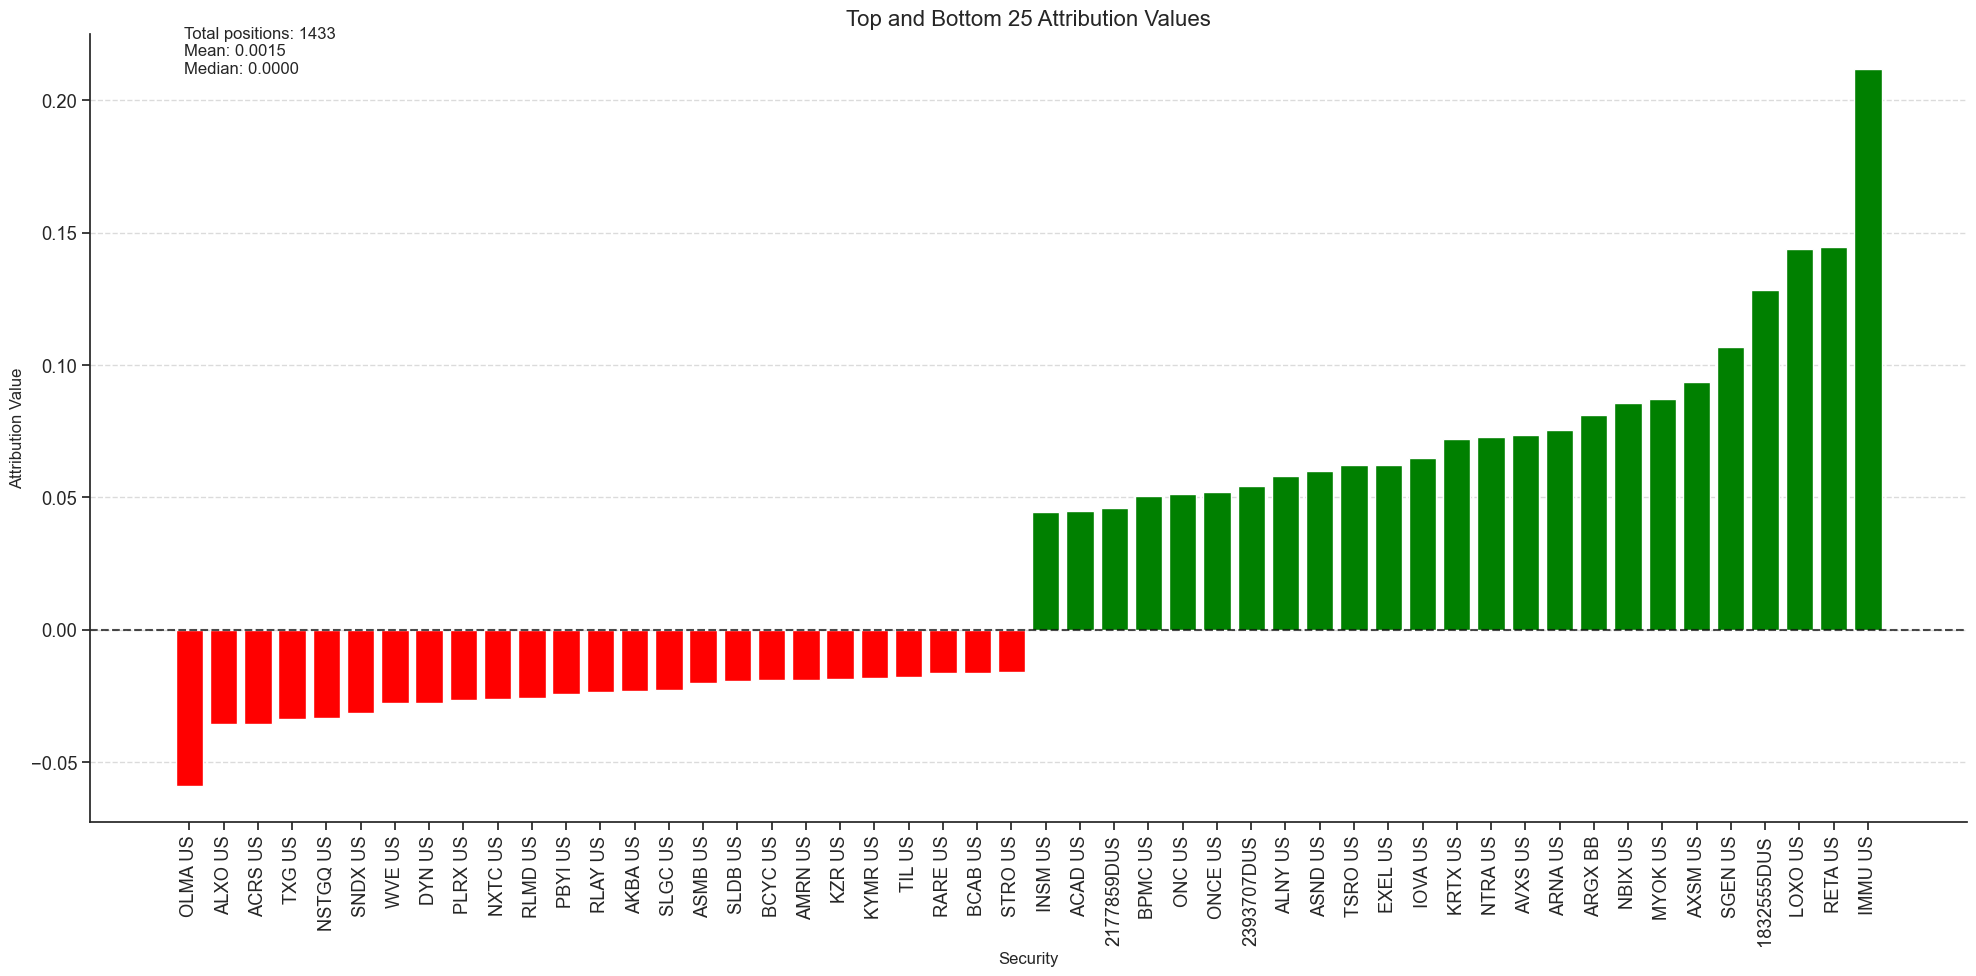

In [185]:
attr = FilingBacktester.carino_attribution(ctr)

# Sort all attribution values from smallest to largest
plot_data = attr.sort_values()

# Get the bottom 25 and top 25 attributions
bottom_25 = plot_data.head(25)
top_25 = plot_data.tail(25)

# Combine them into a single dataframe for plotting
combined_data = pd.concat([bottom_25, top_25])

# Create a bar plot for the top and bottom 25 attributions with wider figure
plt.figure(figsize=(20, 10))
bars = plt.bar(combined_data.index, combined_data.values, color=['red' if x < 0 else 'green' for x in combined_data.values])

# Add labels and title
plt.title('Top and Bottom 25 Attribution Values', fontsize=16)
plt.xlabel('Security', fontsize=12)
plt.ylabel('Attribution Value', fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add summary statistics as text
plt.text(0.05, 0.95, f"Total positions: {len(attr)}\nMean: {plot_data.mean():.4f}\nMedian: {plot_data.median():.4f}", 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


In [184]:
factor_ctr = bt.get_factor_attribution(weights, factor_scores, factor_rets, pd.Timestamp('2025-03-31'))
carino_factor_ctr = FilingBacktester.carino_attribution(factor_ctr)
print(carino_factor_ctr)
print(carino_factor_ctr.sum())
print(carino_factor_ctr/carino_factor_ctr.sum())

Size       -0.865764
Momentum    0.093718
Reversal   -0.299057
Market      0.731810
Idio        0.972957
dtype: float64
0.6336635170713983
Size       -1.366284
Momentum    0.147898
Reversal   -0.471949
Market      1.154887
Idio        1.535448
dtype: float64


In [87]:
# Set the Master fund to analyze
master_fund = "Kynam"  # Change this to the fund you want to analyze

# Get the fund's holdings
holdings = fund_holdings[master_fund]
holdings = bt.adjust_holdings(holdings, max_participation=0.2, port_size=10000000)

perf = bt.get_strategy_returns(holdings, max(holdings.index)+pd.Timedelta(days=90))

# Get XBI returns for comparison
xbi = bt.sec_rets_df['XBI US'].loc[perf.index[0]:perf.index[-1]]
xbi_cum_perf = (1+xbi).cumprod()-1

# Replace NaN values with 0 to avoid issues in cumulative performance calculation
perf = perf.fillna(0)
cum_perf = (1+perf).cumprod()-1

# Calculate trailing 12-month relative performance
trailing_12m = pd.DataFrame({
    master_fund: perf.rolling(252).sum(),
    'XBI': xbi.rolling(252).sum()
})
trailing_12m_relative = trailing_12m[master_fund] - trailing_12m['XBI']

# Calculate regression metrics
X = sm.add_constant(xbi)
model = sm.OLS(perf, X).fit()
beta = model.params[1]
alpha = model.params[0]
alpha_annualized = alpha * 252
idio_vol = np.std(model.resid)
idio_vol_annualized = idio_vol * np.sqrt(252)
information_ratio = alpha_annualized / idio_vol_annualized

# Create a DataFrame for cumulative returns
cumulative_returns = pd.DataFrame({
    master_fund: cum_perf,
    'XBI': xbi_cum_perf
})

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [2, 1]})

# Plot 1: Cumulative Performance
sns.set_style("whitegrid")
sns.lineplot(data=cumulative_returns, dashes=False, ax=ax1)
ax1.set_title(f"Cumulative Performance: {master_fund} vs XBI", fontsize=16)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Cumulative Return", fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title="", loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

# Add text box with metrics to the top left corner of the main plot
metrics_text = (f"Beta to XBI: {beta:.4f}\n"
                f"Alpha (annualized): {alpha_annualized:.4f} or {alpha_annualized*100:.2f}%\n"
                f"Idiosyncratic Vol (ann.): {idio_vol_annualized*100:.2f}%\n"
                f"Information Ratio: {information_ratio:.4f}")

ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Trailing 12-month Relative Performance
sns.lineplot(data=trailing_12m_relative, color='purple', ax=ax2)
ax2.set_title(f"Trailing 12-Month Relative Performance ({master_fund} - XBI)", fontsize=16)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Relative Return", fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

TypeError: 'builtin_function_or_method' object is not subscriptable